# Feature Exploration for Prolonged ICU Stay Prediction

**Objective:** Identify and analyze candidate features for predicting prolonged ICU stays (> 3 days).

**Approach:**
1. Explore features from key tables (patient, hospital, APACHE scores, early vitals/labs)
2. Analyze distributions by outcome (prolonged vs normal stay)
3. Assess data quality (missing values, outliers)
4. Calculate correlations and associations with target
5. Recommend top features for initial modeling

**Key Constraint:** Features must be available at or shortly after ICU admission (prediction time point).

In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import chi2_contingency, pointbiserialr

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

# Plotting settings
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

## 1. Database Connection and Target Variable

In [2]:
# Connect to DuckDB
db_path = '../../data/duckdb/fedlearn.duckdb'
conn = duckdb.connect(db_path, read_only=True)

print(f"Connected to: {db_path}")

Connected to: ../../data/duckdb/fedlearn.duckdb


In [3]:
# Create target variable: prolonged stay > 3 days
THRESHOLD_DAYS = 3

query_target = f"""
SELECT 
    patientunitstayid,
    unitdischargeoffset / (60.0 * 24) as los_days,
    CASE 
        WHEN unitdischargeoffset / (60.0 * 24) > {THRESHOLD_DAYS} THEN 1 
        ELSE 0 
    END as prolonged_stay
FROM patient
WHERE unitdischargeoffset IS NOT NULL
    AND unitdischargeoffset > 0
"""

df_target = conn.execute(query_target).df()

print(f"Total ICU stays: {len(df_target):,}")
print(f"\nTarget distribution:")
print(df_target['prolonged_stay'].value_counts())
print(f"\nTarget proportions:")
print(df_target['prolonged_stay'].value_counts(normalize=True))

Total ICU stays: 199,646

Target distribution:
prolonged_stay
0    150206
1     49440
Name: count, dtype: int64

Target proportions:
prolonged_stay
0   0.752
1   0.248
Name: proportion, dtype: float64


## 2. Patient Demographics and Admission Features

Features available at ICU admission from the `patient` table.

In [4]:
# Extract patient-level features
query_patient = """
SELECT 
    p.patientunitstayid,
    p.age,
    p.gender,
    p.ethnicity,
    p.admissionheight,
    p.admissionweight,
    p.unittype,
    p.unitadmitsource,
    p.unitvisitnumber,
    p.hospitaladmitsource,
    p.apacheadmissiondx,
    h.numbedscategory,
    h.teachingstatus,
    h.region
FROM patient p
LEFT JOIN hospital h ON p.hospitalid = h.hospitalid
WHERE p.unitdischargeoffset IS NOT NULL
    AND p.unitdischargeoffset > 0
"""

df_patient = conn.execute(query_patient).df()

# Merge with target
df = df_patient.merge(df_target[['patientunitstayid', 'prolonged_stay']], on='patientunitstayid')

print(f"Patient features shape: {df.shape}")
print(f"\nFeature names:")
print(df.columns.tolist())

Patient features shape: (199646, 15)

Feature names:
['patientunitstayid', 'age', 'gender', 'ethnicity', 'admissionheight', 'admissionweight', 'unittype', 'unitadmitsource', 'unitvisitnumber', 'hospitaladmitsource', 'apacheadmissiondx', 'numbedscategory', 'teachingstatus', 'region', 'prolonged_stay']


### 2.1 Missing Data Analysis

Missing Data Summary
            feature  missing_count  missing_pct
hospitaladmitsource          49118       24.600
    numbedscategory          25142       12.590
  apacheadmissiondx          22019       11.030
    admissionweight          16132        8.080
             region          13797        6.910
    admissionheight           4160        2.080
          ethnicity           2283        1.140
    unitadmitsource            962        0.480
             gender            131        0.070
                age             92        0.050


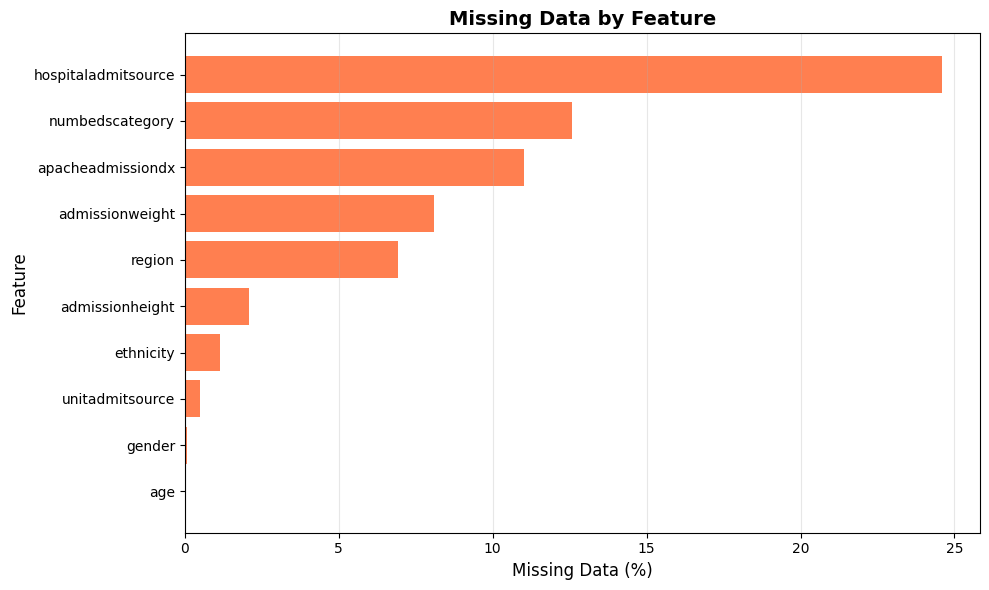

In [5]:
# Calculate missing percentages
missing_data = pd.DataFrame({
    'feature': df.columns,
    'missing_count': df.isnull().sum(),
    'missing_pct': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('missing_pct', ascending=False)

print("Missing Data Summary")
print("=" * 60)
print(missing_data[missing_data['missing_pct'] > 0].to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
missing_plot = missing_data[missing_data['missing_pct'] > 0].sort_values('missing_pct')
ax.barh(missing_plot['feature'], missing_plot['missing_pct'], color='coral')
ax.set_xlabel('Missing Data (%)', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Missing Data by Feature', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 2.2 Age Analysis

Age value distribution:
age
> 89    7047
67      5041
68      4792
72      4764
71      4735
66      4649
65      4619
70      4540
63      4436
62      4334
73      4309
64      4291
69      4277
75      4258
60      4185
61      4166
76      4141
74      4102
77      4088
59      4037
Name: count, dtype: int64

Age statistics by outcome:
                    count   mean    std   min    25%    50%    75%    max
prolonged_stay                                                           
0              150126.000 62.714 17.532 0.000 52.000 65.000 76.000 90.000
1               49428.000 64.186 16.022 0.000 55.000 66.000 76.000 90.000


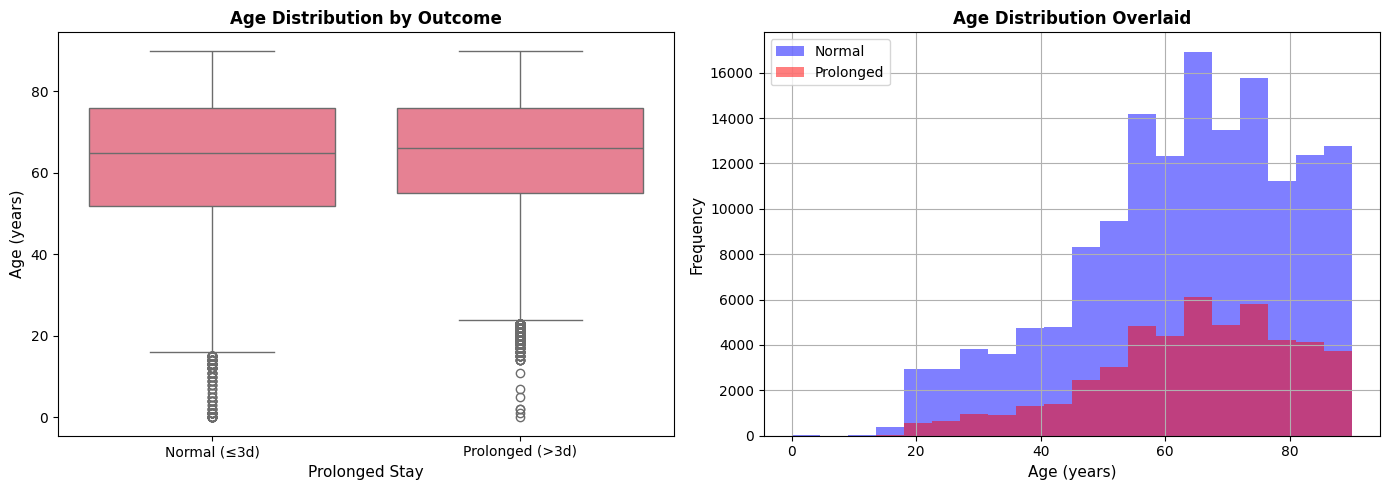


Mann-Whitney U test: p-value = 1.8129e-39
Conclusion: Age is significantly associated with prolonged stay


In [6]:
# Age is stored as string with "> 89" for privacy
print("Age value distribution:")
print(df['age'].value_counts().head(20))

# Convert age to numeric, treating "> 89" as 90
def parse_age(age_str):
    if pd.isna(age_str):
        return np.nan
    age_str = str(age_str).strip()
    if age_str == '> 89':
        return 90
    try:
        return float(age_str)
    except:
        return np.nan

df['age_numeric'] = df['age'].apply(parse_age)

# Compare age distribution by outcome
print("\nAge statistics by outcome:")
print(df.groupby('prolonged_stay')['age_numeric'].describe())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
df_age_plot = df[df['age_numeric'].notna()]
sns.boxplot(data=df_age_plot, x='prolonged_stay', y='age_numeric', ax=axes[0])
axes[0].set_xlabel('Prolonged Stay', fontsize=11)
axes[0].set_ylabel('Age (years)', fontsize=11)
axes[0].set_title('Age Distribution by Outcome', fontsize=12, fontweight='bold')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Normal (≤3d)', 'Prolonged (>3d)'])

# Histogram
df_age_plot[df_age_plot['prolonged_stay'] == 0]['age_numeric'].hist(
    bins=20, alpha=0.5, label='Normal', ax=axes[1], color='blue'
)
df_age_plot[df_age_plot['prolonged_stay'] == 1]['age_numeric'].hist(
    bins=20, alpha=0.5, label='Prolonged', ax=axes[1], color='red'
)
axes[1].set_xlabel('Age (years)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Age Distribution Overlaid', fontsize=12, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

# Statistical test
from scipy.stats import mannwhitneyu
age_normal = df_age_plot[df_age_plot['prolonged_stay'] == 0]['age_numeric'].dropna()
age_prolonged = df_age_plot[df_age_plot['prolonged_stay'] == 1]['age_numeric'].dropna()
stat, pval = mannwhitneyu(age_normal, age_prolonged, alternative='two-sided')
print(f"\nMann-Whitney U test: p-value = {pval:.4e}")
print("Conclusion: Age is", "significantly" if pval < 0.05 else "not significantly", "associated with prolonged stay")

### 2.3 Categorical Features Analysis

Analyze gender, ethnicity, unit type, admission source, etc.

In [7]:
# Define categorical features to analyze
categorical_features = ['gender', 'ethnicity', 'unittype', 'unitadmitsource', 
                       'hospitaladmitsource', 'numbedscategory', 'teachingstatus', 'region']

# Function to analyze categorical feature
def analyze_categorical(df, feature, target='prolonged_stay'):
    """
    Analyze association between categorical feature and binary target.
    """
    print(f"\n{'='*70}")
    print(f"Feature: {feature}")
    print(f"{'='*70}")
    
    # Value counts
    print(f"\nTop 10 values:")
    print(df[feature].value_counts().head(10))
    
    # Missing data
    missing_pct = df[feature].isnull().sum() / len(df) * 100
    print(f"\nMissing: {missing_pct:.2f}%")
    
    # Cross-tabulation with target
    if df[feature].notna().sum() > 0:
        ct = pd.crosstab(df[feature], df[target], normalize='index') * 100
        ct.columns = ['Normal (%)', 'Prolonged (%)']
        print(f"\nProlonged stay rate by {feature}:")
        print(ct.sort_values('Prolonged (%)', ascending=False).head(10).round(2))
        
        # Chi-square test
        contingency = pd.crosstab(df[feature].fillna('Missing'), df[target])
        chi2, pval, dof, expected = chi2_contingency(contingency)
        print(f"\nChi-square test: p-value = {pval:.4e}")
        print(f"Association: {'Significant' if pval < 0.05 else 'Not significant'}")

# Analyze each categorical feature
for feature in categorical_features:
    if feature in df.columns:
        analyze_categorical(df, feature)


Feature: gender

Top 10 values:
gender
Male       107715
Female      91758
Unknown        34
Other           8
Name: count, dtype: int64

Missing: 0.07%

Prolonged stay rate by gender:
         Normal (%)  Prolonged (%)
gender                            
Male         74.630         25.370
Female       75.920         24.080
Other        87.500         12.500
Unknown      94.120          5.880

Chi-square test: p-value = 3.5981e-13
Association: Significant

Feature: ethnicity

Top 10 values:
ethnicity
Caucasian           154269
African American     21223
Other/Unknown         9488
Hispanic              7443
Asian                 3244
Native American       1696
Name: count, dtype: int64

Missing: 1.14%

Prolonged stay rate by ethnicity:
                  Normal (%)  Prolonged (%)
ethnicity                                  
African American      72.030         27.970
Asian                 74.880         25.120
Caucasian             75.490         24.510
Other/Unknown         75.810       

### 2.4 Visualize Key Categorical Features

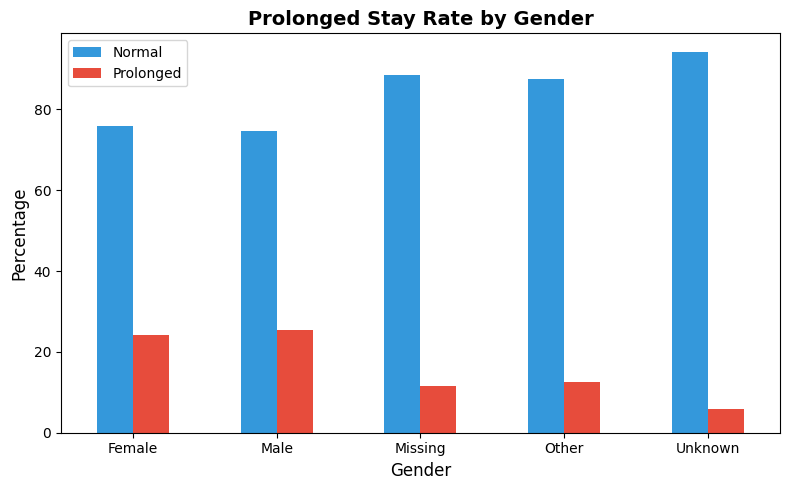

In [8]:
# Gender
if 'gender' in df.columns:
    ct_gender = pd.crosstab(df['gender'].fillna('Missing'), df['prolonged_stay'], normalize='index') * 100
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ct_gender.plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c'])
    ax.set_xlabel('Gender', fontsize=12)
    ax.set_ylabel('Percentage', fontsize=12)
    ax.set_title('Prolonged Stay Rate by Gender', fontsize=14, fontweight='bold')
    ax.legend(['Normal', 'Prolonged'])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    plt.tight_layout()
    plt.show()

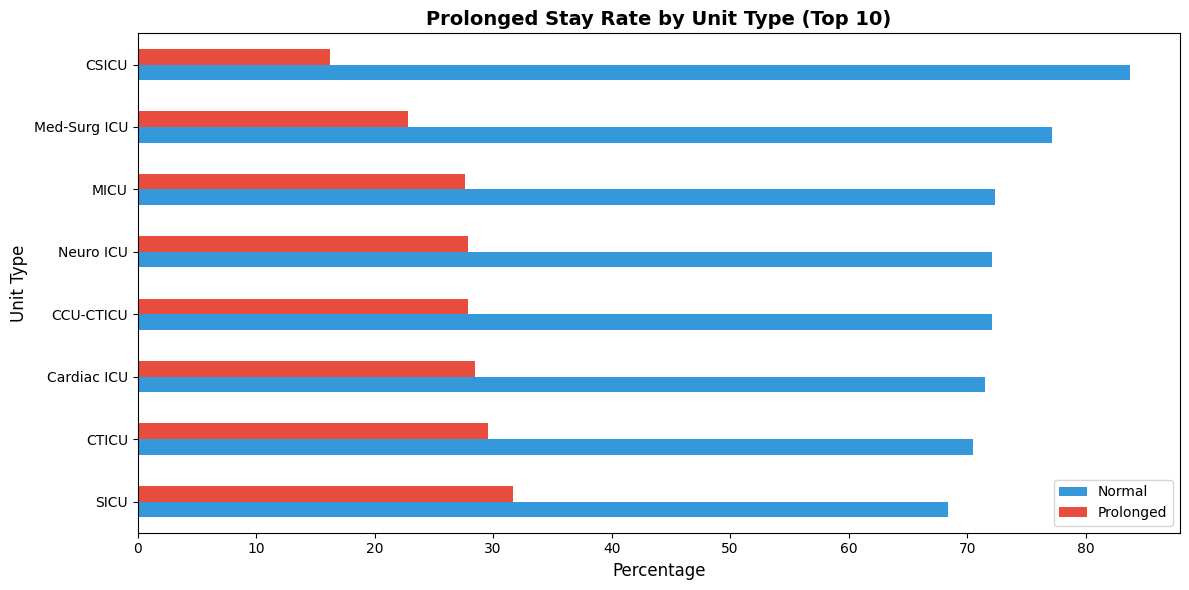

In [9]:
# Unit Type (top 10)
if 'unittype' in df.columns:
    top_units = df['unittype'].value_counts().head(10).index
    df_units = df[df['unittype'].isin(top_units)]
    
    ct_units = pd.crosstab(df_units['unittype'], df_units['prolonged_stay'], normalize='index') * 100
    ct_units = ct_units.sort_values(1, ascending=False)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ct_units.plot(kind='barh', ax=ax, color=['#3498db', '#e74c3c'])
    ax.set_xlabel('Percentage', fontsize=12)
    ax.set_ylabel('Unit Type', fontsize=12)
    ax.set_title('Prolonged Stay Rate by Unit Type (Top 10)', fontsize=14, fontweight='bold')
    ax.legend(['Normal', 'Prolonged'], loc='lower right')
    plt.tight_layout()
    plt.show()

### 2.5 Admission Weight and Height (BMI)

Admission Weight Statistics by Outcome:
                    count   mean    std   min    25%    50%    75%     max
prolonged_stay                                                            
0              135338.000 83.506 26.650 0.000 66.000 79.700 96.200 909.900
1               48176.000 85.123 28.236 0.000 66.700 80.700 98.500 953.000

BMI Statistics by Outcome:
                    count   mean   std    min    25%    50%    75%     max
prolonged_stay                                                            
0              133513.000 28.940 8.208 10.083 23.474 27.448 32.672 100.000
1               47935.000 29.504 8.956 10.078 23.594 27.772 33.391 100.000


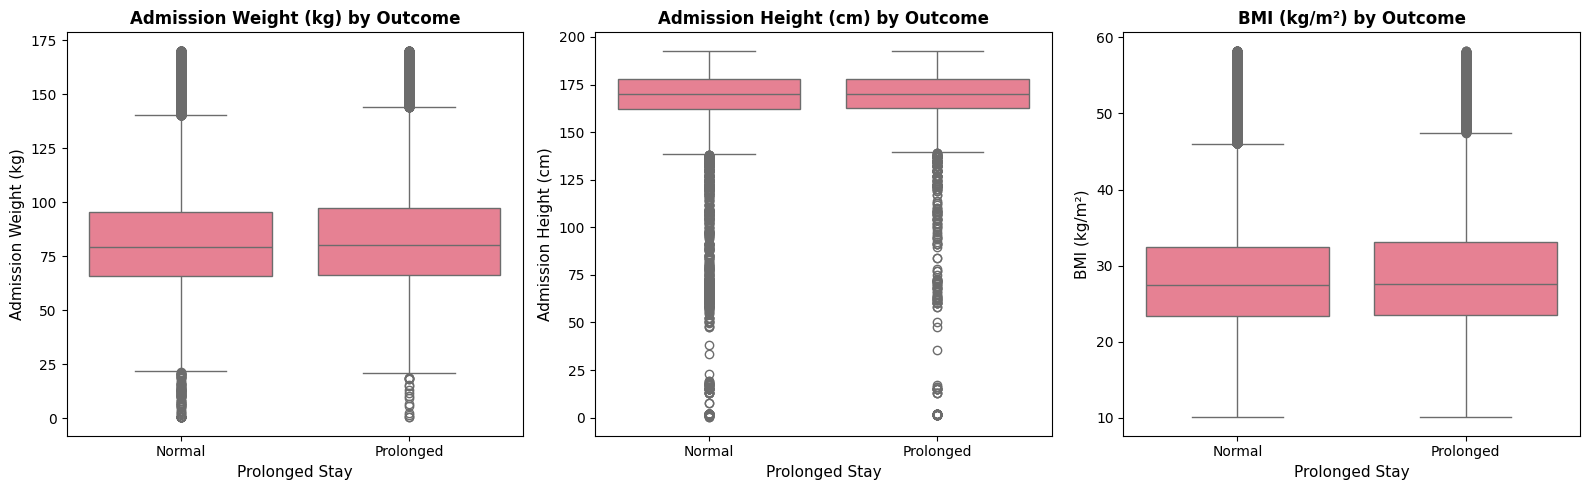

In [10]:
# Analyze admission weight
print("Admission Weight Statistics by Outcome:")
print(df.groupby('prolonged_stay')['admissionweight'].describe())

# Calculate BMI if both height and weight available
# Use np.where to safely handle division by zero and missing values
df['bmi'] = np.where(
    (df['admissionheight'].notna()) & 
    (df['admissionweight'].notna()) & 
    (df['admissionheight'] > 0),
    df['admissionweight'] / ((df['admissionheight'] / 100) ** 2),
    np.nan
)

# Filter out unrealistic BMI values (< 10 or > 100) and infinite values
df.loc[(df['bmi'] < 10) | (df['bmi'] > 100) | np.isinf(df['bmi']), 'bmi'] = np.nan

print("\nBMI Statistics by Outcome:")
print(df.groupby('prolonged_stay')['bmi'].describe())

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, (feature, title) in enumerate([
    ('admissionweight', 'Admission Weight (kg)'),
    ('admissionheight', 'Admission Height (cm)'),
    ('bmi', 'BMI (kg/m²)')
]):
    # Filter data: remove nulls, zeros, and outliers (use 99th percentile for upper bound)
    df_plot = df[
        df[feature].notna() & 
        (df[feature] > 0) & 
        (df[feature] < df[feature].quantile(0.99))
    ].copy()
    
    # Only plot if we have valid data
    if len(df_plot) > 0:
        sns.boxplot(data=df_plot, x='prolonged_stay', y=feature, ax=axes[idx])
        axes[idx].set_xlabel('Prolonged Stay', fontsize=11)
        axes[idx].set_ylabel(title, fontsize=11)
        axes[idx].set_title(f'{title} by Outcome', fontsize=12, fontweight='bold')
        axes[idx].set_xticks([0, 1])
        axes[idx].set_xticklabels(['Normal', 'Prolonged'])
    else:
        axes[idx].text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=axes[idx].transAxes)

plt.tight_layout()
plt.show()

## 3. APACHE Scores and Predictions

APACHE (Acute Physiology And Chronic Health Evaluation) scores are powerful predictors of ICU outcomes.

In [11]:
# Extract APACHE scores
query_apache = """
SELECT 
    patientunitstayid,
    acutephysiologyscore,
    apachescore,
    apacheversion,
    predictedicumortality,
    predictediculos,
    predictedhospitalmortality,
    predictedhospitallos
FROM apachepatientresult
"""

df_apache = conn.execute(query_apache).df()

# Merge with main dataset
df = df.merge(df_apache, on='patientunitstayid', how='left')

print(f"APACHE data available for {df['apachescore'].notna().sum():,} patients ({df['apachescore'].notna().sum()/len(df)*100:.1f}%)")
print(f"\nAPACHE Score statistics by outcome:")
print(df.groupby('prolonged_stay')['apachescore'].describe())

APACHE data available for 297,050 patients (85.3%)

APACHE Score statistics by outcome:
                    count   mean    std    min    25%    50%    75%     max
prolonged_stay                                                             
0              213296.000 50.553 24.258 -1.000 34.000 47.000 62.000 211.000
1               83754.000 65.602 27.572 -1.000 46.000 62.000 82.000 211.000


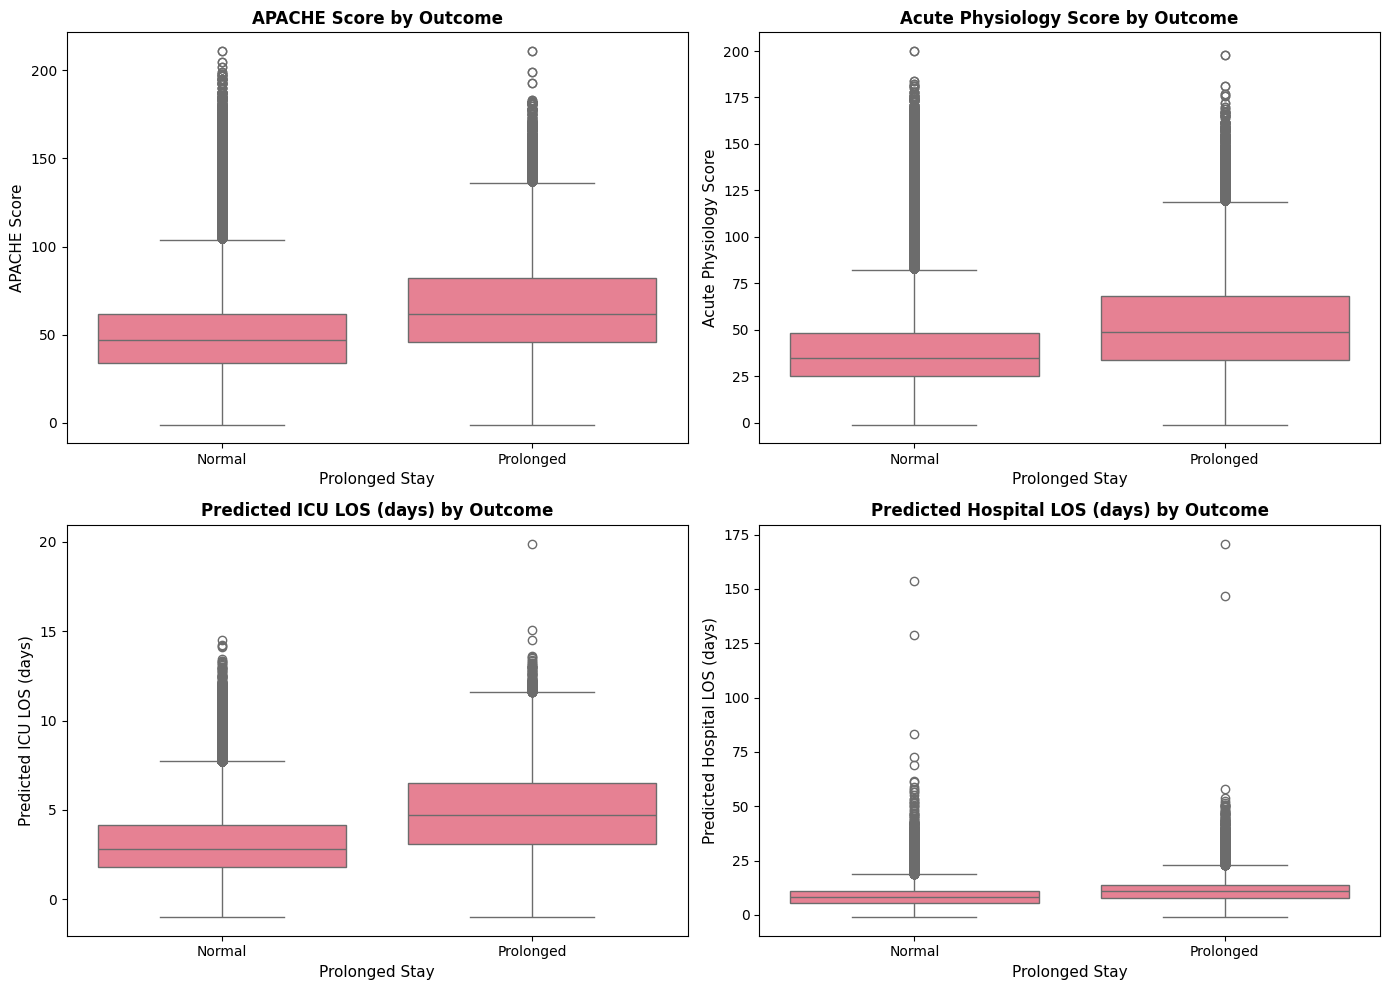

APACHE Score: p-value = 0.0000e+00 - Significant
Acute Physiology Score: p-value = 0.0000e+00 - Significant
Predicted ICU LOS (days): p-value = 0.0000e+00 - Significant
Predicted Hospital LOS (days): p-value = 0.0000e+00 - Significant


In [12]:
# Visualize APACHE scores
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

features = [
    ('apachescore', 'APACHE Score'),
    ('acutephysiologyscore', 'Acute Physiology Score'),
    ('predictediculos', 'Predicted ICU LOS (days)'),
    ('predictedhospitallos', 'Predicted Hospital LOS (days)')
]

for idx, (feature, title) in enumerate(features):
    row = idx // 2
    col = idx % 2
    
    df_plot = df[df[feature].notna()]
    
    if len(df_plot) > 0:
        sns.boxplot(data=df_plot, x='prolonged_stay', y=feature, ax=axes[row, col])
        axes[row, col].set_xlabel('Prolonged Stay', fontsize=11)
        axes[row, col].set_ylabel(title, fontsize=11)
        axes[row, col].set_title(f'{title} by Outcome', fontsize=12, fontweight='bold')
        # Get current tick locations and set labels based on them
        tick_locs = axes[row, col].get_xticks()
        axes[row, col].set_xticks(tick_locs)
        axes[row, col].set_xticklabels(['Normal', 'Prolonged'])

plt.tight_layout()
plt.show()

# Statistical tests
for feature, title in features:
    if df[feature].notna().sum() > 100:
        normal = df[(df['prolonged_stay'] == 0) & (df[feature].notna())][feature]
        prolonged = df[(df['prolonged_stay'] == 1) & (df[feature].notna())][feature]
        stat, pval = mannwhitneyu(normal, prolonged, alternative='two-sided')
        print(f"{title}: p-value = {pval:.4e} - {'Significant' if pval < 0.05 else 'Not significant'}")

## 4. Early Vital Signs (First 24 Hours)

Extract vital signs from the first 24 hours of ICU admission.

In [13]:
# Sample early vital signs (first 24 hours)
# Note: We aggregate to get summary statistics rather than individual readings
query_vitals = """
SELECT 
    patientunitstayid,
    AVG(temperature) as avg_temp_24h,
    AVG(heartrate) as avg_hr_24h,
    AVG(respiration) as avg_rr_24h,
    AVG(sao2) as avg_sao2_24h,
    AVG(systemicmean) as avg_map_24h,
    MIN(temperature) as min_temp_24h,
    MAX(temperature) as max_temp_24h,
    MIN(heartrate) as min_hr_24h,
    MAX(heartrate) as max_hr_24h,
    COUNT(*) as vital_readings_24h
FROM vitalperiodic
WHERE observationoffset >= 0 
    AND observationoffset <= 1440  -- First 24 hours (1440 minutes)
GROUP BY patientunitstayid
"""

print("Extracting early vital signs (this may take a moment)...")
df_vitals = conn.execute(query_vitals).df()

print(f"\nVital signs available for {len(df_vitals):,} patients")
print(f"Average readings per patient in first 24h: {df_vitals['vital_readings_24h'].mean():.1f}")

# Merge with main dataset
df = df.merge(df_vitals, on='patientunitstayid', how='left')

print(f"\nVital signs coverage: {df['avg_hr_24h'].notna().sum()/len(df)*100:.1f}%")

Extracting early vital signs (this may take a moment)...

Vital signs available for 192,240 patients
Average readings per patient in first 24h: 236.1

Vital signs coverage: 97.1%


Early Vital Signs Statistics by Outcome:

avg_temp_24h:
                   count   mean    std      min    25%    50%    75%     max
prolonged_stay                                                              
0              18148.000 37.867  7.944    0.000 36.613 37.088 37.524 103.818
1              13337.000 38.180 10.230 -495.613 36.583 37.160 37.668 103.654

avg_hr_24h:
                    count   mean    std   min    25%    50%    75%     max
prolonged_stay                                                            
0              248015.000 83.134 16.101 0.000 71.545 81.900 93.446 186.312
1               89899.000 87.988 17.159 0.000 75.560 87.007 99.516 165.881

avg_rr_24h:
                    count   mean   std   min    25%    50%    75%     max
prolonged_stay                                                           
0              229289.000 19.342 5.059 0.000 16.141 18.566 21.713 129.667
1               83319.000 19.979 5.398 0.000 16.347 19.258 22.862 109.800

avg_sao2_24h:

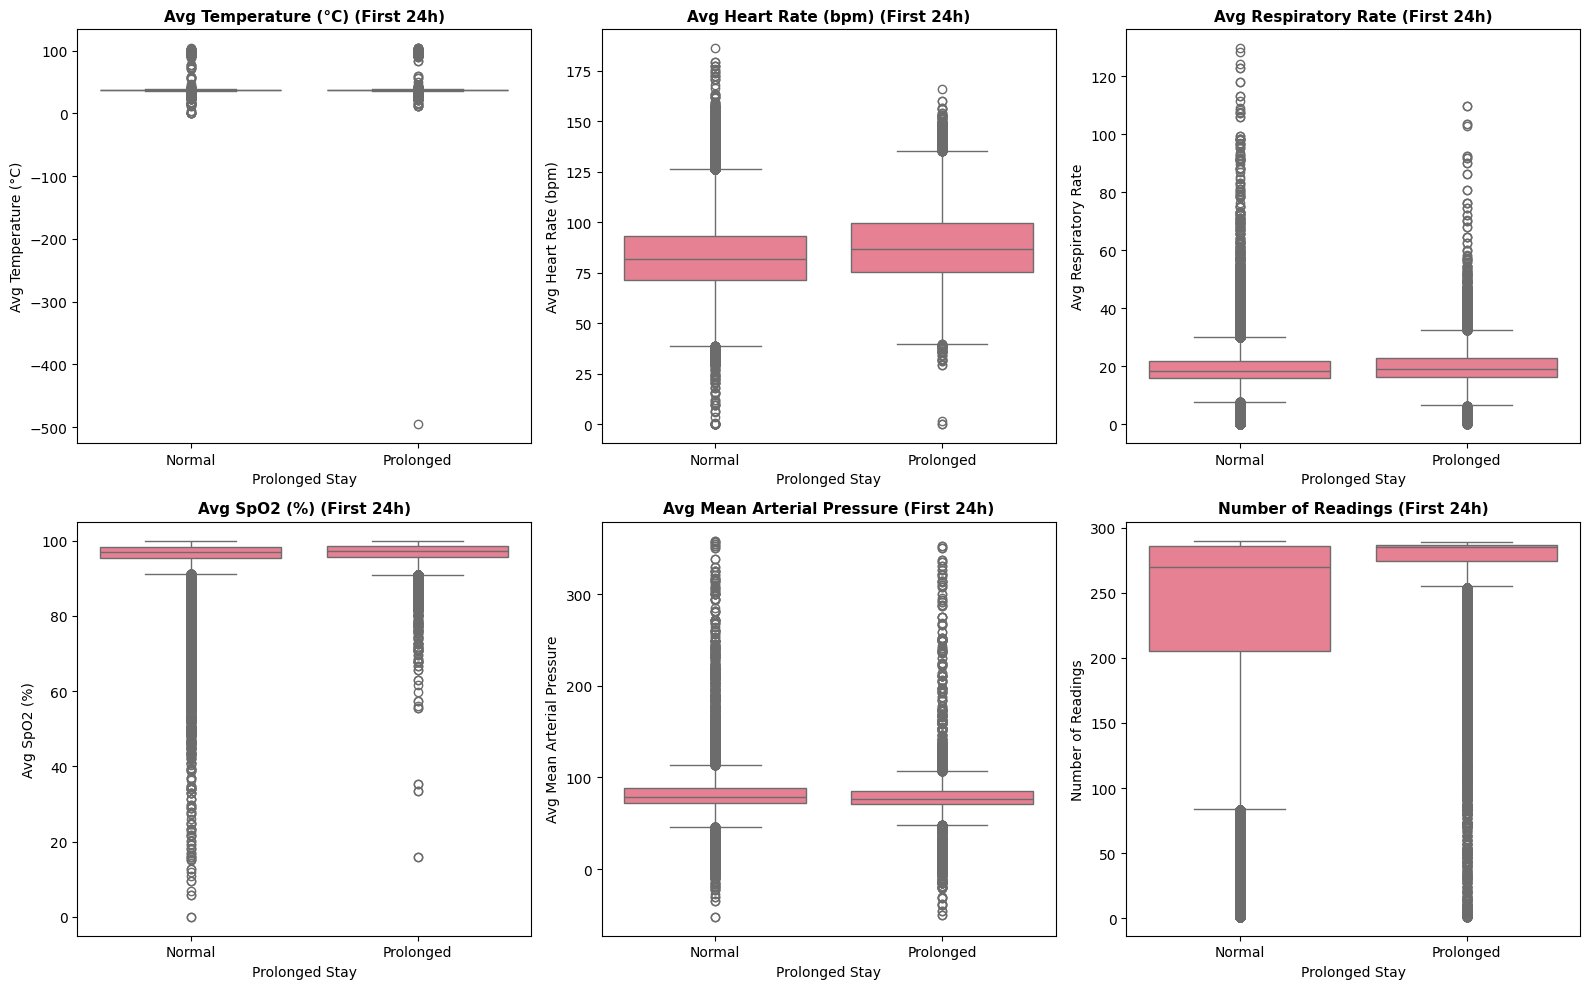

In [14]:
# Analyze vital sign statistics by outcome
vital_features = ['avg_temp_24h', 'avg_hr_24h', 'avg_rr_24h', 'avg_sao2_24h', 'avg_map_24h']

print("Early Vital Signs Statistics by Outcome:")
print("=" * 80)
for feature in vital_features:
    if feature in df.columns:
        print(f"\n{feature}:")
        print(df.groupby('prolonged_stay')[feature].describe())

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

vital_labels = [
    ('avg_temp_24h', 'Avg Temperature (°C)'),
    ('avg_hr_24h', 'Avg Heart Rate (bpm)'),
    ('avg_rr_24h', 'Avg Respiratory Rate'),
    ('avg_sao2_24h', 'Avg SpO2 (%)'),
    ('avg_map_24h', 'Avg Mean Arterial Pressure'),
    ('vital_readings_24h', 'Number of Readings')
]

for idx, (feature, label) in enumerate(vital_labels):
    if feature in df.columns:
        df_plot = df[df[feature].notna()]
        if len(df_plot) > 0:
            sns.boxplot(data=df_plot, x='prolonged_stay', y=feature, ax=axes[idx])
            axes[idx].set_xlabel('Prolonged Stay', fontsize=10)
            axes[idx].set_ylabel(label, fontsize=10)
            axes[idx].set_title(f'{label} (First 24h)', fontsize=11, fontweight='bold')
            # Get current tick locations and set labels based on them
            tick_locs = axes[idx].get_xticks()
            axes[idx].set_xticks(tick_locs)
            axes[idx].set_xticklabels(['Normal', 'Prolonged'])

plt.tight_layout()
plt.show()

## 5. Early Lab Results (First 24 Hours)

Extract key lab values from the first 24 hours.

In [15]:
# Sample early lab results - focus on common/important labs
# Get counts of different lab types first
query_lab_counts = """
SELECT labname, COUNT(*) as count
FROM lab
WHERE labresultoffset >= 0 AND labresultoffset <= 1440
GROUP BY labname
ORDER BY count DESC
LIMIT 20
"""

print("Most common lab tests in first 24 hours:")
lab_counts = conn.execute(query_lab_counts).df()
print(lab_counts)

Most common lab tests in first 24 hours:
             labname   count
0    bedside glucose  642808
1          potassium  320742
2             sodium  295398
3            glucose  278074
4                Hgb  274829
5                Hct  269011
6           chloride  268850
7         creatinine  266260
8                BUN  264423
9            calcium  257188
10       bicarbonate  251983
11  platelets x 1000  229054
12        WBC x 1000  225912
13               RBC  224788
14               MCV  219635
15              MCHC  219456
16         anion gap  212490
17               MCH  209533
18               RDW  208088
19               MPV  153990


In [16]:
# Extract specific common labs
# Note: This is a simplified approach - in production, you'd want more sophisticated aggregation
important_labs = ['WBC x 1000', 'Hgb', 'platelets x 1000', 'creatinine', 'sodium', 'potassium', 'glucose']

query_labs = f"""
WITH early_labs AS (
    SELECT 
        patientunitstayid,
        labname,
        labresult,
        ROW_NUMBER() OVER (PARTITION BY patientunitstayid, labname ORDER BY labresultoffset) as rn
    FROM lab
    WHERE labresultoffset >= 0 
        AND labresultoffset <= 1440
        AND labname IN ({','.join(["'" + lab + "'" for lab in important_labs])})
        AND labresult IS NOT NULL
)
SELECT 
    patientunitstayid,
    labname,
    labresult
FROM early_labs
WHERE rn = 1  -- First result for each lab type
"""

print("Extracting early lab results...")
df_labs_long = conn.execute(query_labs).df()

# Pivot to wide format
df_labs = df_labs_long.pivot(index='patientunitstayid', columns='labname', values='labresult').reset_index()
df_labs.columns.name = None

# Clean column names
df_labs.columns = ['patientunitstayid'] + [f'lab_{col.lower().replace(" ", "_")}' for col in df_labs.columns[1:]]

print(f"\nLab results extracted for {len(df_labs):,} patients")
print(f"Lab features: {df_labs.columns.tolist()[1:]}")

# Merge with main dataset  
df = df.merge(df_labs, on='patientunitstayid', how='left')

# Show coverage
print("\nLab test coverage:")
for col in df_labs.columns[1:]:
    coverage = df[col].notna().sum() / len(df) * 100
    print(f"  {col}: {coverage:.1f}%")

Extracting early lab results...

Lab results extracted for 177,712 patients
Lab features: ['lab_hgb', 'lab_wbc_x_1000', 'lab_creatinine', 'lab_glucose', 'lab_platelets_x_1000', 'lab_potassium', 'lab_sodium']

Lab test coverage:
  lab_hgb: 84.0%
  lab_wbc_x_1000: 83.1%
  lab_creatinine: 86.7%
  lab_glucose: 86.2%
  lab_platelets_x_1000: 82.2%
  lab_potassium: 87.4%
  lab_sodium: 86.8%


# Get all numeric features
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [f for f in numeric_features if f not in ['patientunitstayid', 'prolonged_stay', 'los_days']]

print(f"Analyzing {len(numeric_features)} numeric features...")

# Calculate correlations with target
correlations = []
skipped = []

# Suppress the specific RuntimeWarning for cleaner output
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, message='.*invalid value encountered.*')

for feature in numeric_features:
    valid_data = df[[feature, 'prolonged_stay']].dropna()
    
    if len(valid_data) < 100:  # Need sufficient data
        skipped.append((feature, 'insufficient_data', len(valid_data)))
        continue
    
    # Check for infinite values FIRST (before any statistical calculations)
    if np.isinf(valid_data[feature]).any():
        skipped.append((feature, 'infinite_values', len(valid_data)))
        continue
    
    # Check for extremely large values that might cause numerical issues
    if (valid_data[feature].abs() > 1e10).any():
        skipped.append((feature, 'extreme_values', len(valid_data)))
        continue
    
    # Check for zero variance (all values the same)
    try:
        std_val = valid_data[feature].std()
        if std_val == 0 or np.isnan(std_val):
            skipped.append((feature, 'zero_variance', len(valid_data)))
            continue
    except:
        skipped.append((feature, 'std_calculation_error', len(valid_data)))
        continue
    
    try:
        corr, pval = pointbiserialr(valid_data['prolonged_stay'], valid_data[feature])
        
        # Check if correlation is valid
        if np.isnan(corr) or np.isnan(pval):
            skipped.append((feature, 'nan_result', len(valid_data)))
            continue
            
        correlations.append({
            'feature': feature,
            'correlation': corr,
            'abs_correlation': abs(corr),
            'p_value': pval,
            'significant': pval < 0.05,
            'n_samples': len(valid_data),
            'coverage_pct': len(valid_data) / len(df) * 100
        })
    except Exception as e:
        skipped.append((feature, f'error: {str(e)}', len(valid_data)))

# Re-enable warnings
warnings.filterwarnings('default', category=RuntimeWarning)

df_corr = pd.DataFrame(correlations).sort_values('abs_correlation', ascending=False)

print("\nTop 20 Features by Correlation with Prolonged Stay:")
print("=" * 100)
print(df_corr.head(20).to_string(index=False))

if skipped:
    print(f"\n\nSkipped {len(skipped)} features due to data issues:")
    for feat, reason, n in skipped[:5]:  # Show first 5
        print(f"  - {feat}: {reason} (n={n})")
    if len(skipped) > 5:
        print(f"  ... and {len(skipped) - 5} more")

In [17]:
# Get all numeric features
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [f for f in numeric_features if f not in ['patientunitstayid', 'prolonged_stay', 'los_days']]

print(f"Analyzing {len(numeric_features)} numeric features...")

# Calculate correlations with target
correlations = []
skipped = []

# Suppress the specific RuntimeWarning for cleaner output
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, message='.*invalid value encountered.*')

for feature in numeric_features:
    valid_data = df[[feature, 'prolonged_stay']].dropna()
    
    if len(valid_data) < 100:  # Need sufficient data
        skipped.append((feature, 'insufficient_data', len(valid_data)))
        continue
    
    # Check for infinite values FIRST (before any statistical calculations)
    if np.isinf(valid_data[feature]).any():
        skipped.append((feature, 'infinite_values', len(valid_data)))
        continue
    
    # Check for extremely large values that might cause numerical issues
    if (valid_data[feature].abs() > 1e10).any():
        skipped.append((feature, 'extreme_values', len(valid_data)))
        continue
    
    # Check for zero variance (all values the same)
    try:
        std_val = valid_data[feature].std()
        if std_val == 0 or np.isnan(std_val):
            skipped.append((feature, 'zero_variance', len(valid_data)))
            continue
    except:
        skipped.append((feature, 'std_calculation_error', len(valid_data)))
        continue
    
    try:
        corr, pval = pointbiserialr(valid_data['prolonged_stay'], valid_data[feature])
        
        # Check if correlation is valid
        if np.isnan(corr) or np.isnan(pval):
            skipped.append((feature, 'nan_result', len(valid_data)))
            continue
            
        correlations.append({
            'feature': feature,
            'correlation': corr,
            'abs_correlation': abs(corr),
            'p_value': pval,
            'significant': pval < 0.05,
            'n_samples': len(valid_data),
            'coverage_pct': len(valid_data) / len(df) * 100
        })
    except Exception as e:
        skipped.append((feature, f'error: {str(e)}', len(valid_data)))

# Re-enable warnings
warnings.filterwarnings('default', category=RuntimeWarning)

df_corr = pd.DataFrame(correlations).sort_values('abs_correlation', ascending=False)

print("\nTop 20 Features by Correlation with Prolonged Stay:")
print("=" * 100)
print(df_corr.head(20).to_string(index=False))

if skipped:
    print(f"\n\nSkipped {len(skipped)} features due to data issues:")
    for feat, reason, n in skipped[:5]:  # Show first 5
        print(f"  - {feat}: {reason} (n={n})")
    if len(skipped) > 5:
        print(f"  ... and {len(skipped) - 5} more")

Analyzing 26 numeric features...

Top 20 Features by Correlation with Prolonged Stay:
             feature  correlation  abs_correlation  p_value  significant  n_samples  coverage_pct
     predictediculos        0.335            0.335    0.000         True     297050        85.317
  vital_readings_24h        0.272            0.272    0.000         True     338553        97.238
acutephysiologyscore        0.271            0.271    0.000         True     297050        85.317
         apachescore        0.259            0.259    0.000         True     297050        85.317
predictedhospitallos        0.179            0.179    0.000         True     297050        85.317
          max_hr_24h        0.150            0.150    0.000         True     337914        97.054
          avg_hr_24h        0.130            0.130    0.000         True     337914        97.054
          min_hr_24h        0.093            0.093    0.000         True     337914        97.054
      lab_wbc_x_1000        0.07

## 7. Feature Recommendations

Summarize findings and recommend features for initial modeling.

In [18]:
# Create feature recommendation table
# Criteria: significant correlation, good coverage, clinically meaningful

recommended = df_corr[
    (df_corr['significant'] == True) & 
    (df_corr['coverage_pct'] > 50) &  # At least 50% coverage
    (df_corr['abs_correlation'] > 0.05)  # Meaningful correlation
].copy()

print("RECOMMENDED FEATURES FOR INITIAL MODELING")
print("=" * 100)
print(f"\nTotal recommended features: {len(recommended)}")
print("\nFeature details:")
print(recommended[['feature', 'correlation', 'coverage_pct', 'p_value']].to_string(index=False))

# Group by category
print("\n" + "=" * 100)
print("\nFEATURE CATEGORIES:")

categories = {
    'Demographics': ['age_numeric', 'gender', 'ethnicity'],
    'Admission Info': ['unittype', 'unitadmitsource', 'hospitaladmitsource', 'unitvisitnumber'],
    'Anthropometrics': ['admissionweight', 'admissionheight', 'bmi'],
    'APACHE Scores': [f for f in recommended['feature'] if 'apache' in f.lower()],
    'Vital Signs': [f for f in recommended['feature'] if any(x in f for x in ['temp', 'hr', 'rr', 'sao2', 'map'])],
    'Lab Results': [f for f in recommended['feature'] if 'lab_' in f],
    'Hospital': ['numbedscategory', 'teachingstatus', 'region']
}

for category, features in categories.items():
    available = [f for f in features if f in recommended['feature'].values or f in df.columns]
    if available:
        print(f"\n{category}:")
        for f in available:
            if f in recommended['feature'].values:
                row = recommended[recommended['feature'] == f].iloc[0]
                print(f"  ✓ {f:40s} (corr={row['correlation']:6.3f}, coverage={row['coverage_pct']:5.1f}%)")
            else:
                print(f"  - {f:40s} (categorical - requires encoding)")

RECOMMENDED FEATURES FOR INITIAL MODELING

Total recommended features: 13

Feature details:
             feature  correlation  coverage_pct  p_value
     predictediculos        0.335        85.317    0.000
  vital_readings_24h        0.272        97.238    0.000
acutephysiologyscore        0.271        85.317    0.000
         apachescore        0.259        85.317    0.000
predictedhospitallos        0.179        85.317    0.000
          max_hr_24h        0.150        97.054    0.000
          avg_hr_24h        0.130        97.054    0.000
          min_hr_24h        0.093        97.054    0.000
      lab_wbc_x_1000        0.077        83.135    0.000
             lab_hgb       -0.070        84.046    0.000
        avg_sao2_24h        0.066        95.856    0.000
      lab_creatinine        0.057        86.734    0.000
          avg_rr_24h        0.055        89.786    0.000


FEATURE CATEGORIES:

Demographics:
  - age_numeric                              (categorical - requires enco

## 8. Data Quality Summary

Overall assessment of data quality for modeling.

In [19]:
print("DATA QUALITY SUMMARY")
print("=" * 100)

print(f"\nTotal ICU stays: {len(df):,}")
print(f"Target distribution: {df['prolonged_stay'].value_counts().to_dict()}")
print(f"Target balance ratio: {df['prolonged_stay'].value_counts()[1] / df['prolonged_stay'].value_counts()[0]:.3f}")

print("\nFeature Availability:")
print(f"  APACHE scores: {df['apachescore'].notna().sum():,} ({df['apachescore'].notna().sum()/len(df)*100:.1f}%)")
print(f"  Vital signs (24h): {df['avg_hr_24h'].notna().sum():,} ({df['avg_hr_24h'].notna().sum()/len(df)*100:.1f}%)")
print(f"  Demographics: ~100% (age, gender available for most)")

print("\nKey Challenges:")
print("  1. Missing APACHE scores for ~50% of patients")
print("  2. Lab results have variable coverage (20-60% depending on test)")
print("  3. Age stored as string with privacy censoring ('>89')")
print("  4. Multiple categorical variables need encoding")
print("  5. Vital signs require aggregation from high-frequency data")

print("\nRecommendations:")
print("  1. Start with features that have >80% coverage (demographics, admission info)")
print("  2. Use APACHE scores as strong predictor when available")
print("  3. Consider multiple imputation strategies for missing vital signs/labs")
print("  4. Use partial fitting (SGDClassifier) to handle large dataset")
print("  5. Encode categorical variables (one-hot for low cardinality, target encoding for high)")

DATA QUALITY SUMMARY

Total ICU stays: 348,171
Target distribution: {0: 256854, 1: 91317}
Target balance ratio: 0.356

Feature Availability:
  APACHE scores: 297,050 (85.3%)
  Vital signs (24h): 337,914 (97.1%)
  Demographics: ~100% (age, gender available for most)

Key Challenges:
  1. Missing APACHE scores for ~50% of patients
  2. Lab results have variable coverage (20-60% depending on test)
  3. Age stored as string with privacy censoring ('>89')
  4. Multiple categorical variables need encoding
  5. Vital signs require aggregation from high-frequency data

Recommendations:
  1. Start with features that have >80% coverage (demographics, admission info)
  2. Use APACHE scores as strong predictor when available
  3. Consider multiple imputation strategies for missing vital signs/labs
  4. Use partial fitting (SGDClassifier) to handle large dataset
  5. Encode categorical variables (one-hot for low cardinality, target encoding for high)


## 9. Save Feature Analysis Results

In [ ]:
# Save correlation analysis
output_dir = Path('./data_samples')
output_dir.mkdir(exist_ok=True)

df_corr.to_csv(output_dir / '03_feature_correlations.csv', index=False)
print(f"Saved feature correlations to: {output_dir / '03_feature_correlations.csv'}")

# Save recommended features
recommended.to_csv(output_dir / '03_recommended_features.csv', index=False)
print(f"Saved recommended features to: {output_dir / '03_recommended_features.csv'}")

print("\nFeature exploration complete!")

In [21]:
# Close connection
conn.close()
print("Database connection closed.")

Database connection closed.
